In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

In [7]:
df=pd.read_csv("Data.csv")

In [8]:
df

,Amount Pending,State,Tenure,Interest Rate,City,Bounce String,Disbursed Amount,Loan Number
0,963,Karnataka,11,7.69,Bangalore,SSS,10197,JZ6FS
1,1194,Karnataka,11,6.16,Bangalore,SSB,12738,RDIOY
2,1807,Karnataka,14,4.24,Hassan,BBS,24640,WNW4L
3,2451,Karnataka,10,4.70,Bangalore,SSS,23990,6LBJS
4,2611,Karnataka,10,4.41,Mysore,SSB,25590,ZFZUA
...,...,...,...,...,...,...,...,...
24577,899,Andhra Pradesh,8,0.00,Chittoor,FEMI,7192,EAX5C
24578,2699,Andhra Pradesh,8,0.00,Krishna,FEMI,21592,5MCE9
24579,1540,Andhra Pradesh,8,0.00,Krishna,FEMI,12320,9HO4Q
24580,824,Andhra Pradesh,8,0.00,Guntur,FEMI,6592,3VV72


In [10]:
df.isnull().sum()

Amount Pending      0
State               0
Tenure              0
Interest Rate       0
City                0
Bounce String       0
Disbursed Amount    0
Loan Number         0
dtype: int64

## Calculate the risk labels for all the borrowers. 

In [29]:
# Derive risk labels
def risk_label(bounce_string):
    # Count number of bounces in last 6 months excluding the last month
    bounces = bounce_string[:-1].count('B') + bounce_string[:-1].count('L')
    
    if bounce_string.endswith('S') or bounce_string.endswith('H'):
        if bounces == 0:
            return 'Low risk'
        elif bounces < 2:
            return 'Medium risk'
        else:
            return 'High risk'
    elif bounce_string.startswith('FEMI'):
        return 'Unknown risk'
    else:
        return 'High risk'

# Apply risk label calculation to each row
df['Risk Label'] = df['Bounce String'].apply(risk_label)



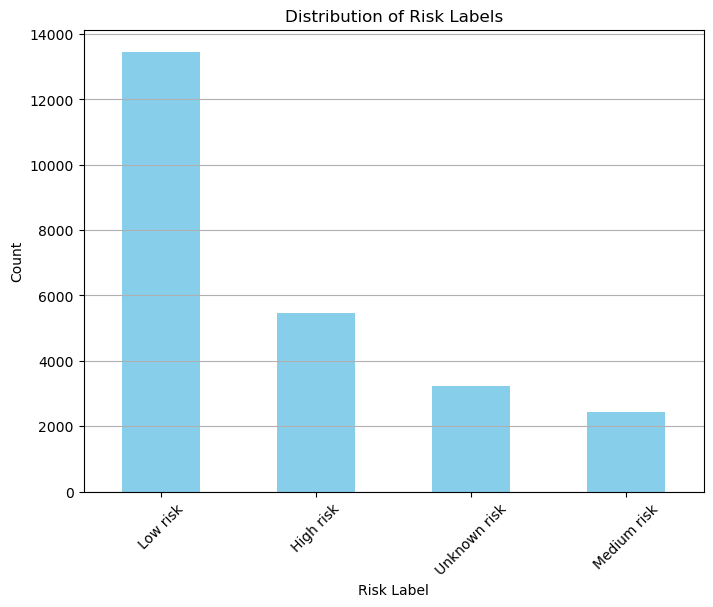

In [18]:
# Count the occurrences of each risk label
risk_label_counts = df['Risk Label'].value_counts()

# Plot the distribution of risk labels
plt.figure(figsize=(8, 6))
risk_label_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Risk Labels')
plt.xlabel('Risk Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## label all customers based on where they are in their tenure

In [25]:
def calculate_tenure_label(tenure):
    if tenure <= 3:
        return 'Early tenure'
    elif tenure <= 21:
        return 'Mid tenure'
    else:
        return 'Late tenure'

# Apply tenure label calculation to each row
df['Tenure Label'] = df['Tenure'].apply(calculate_tenure_label)



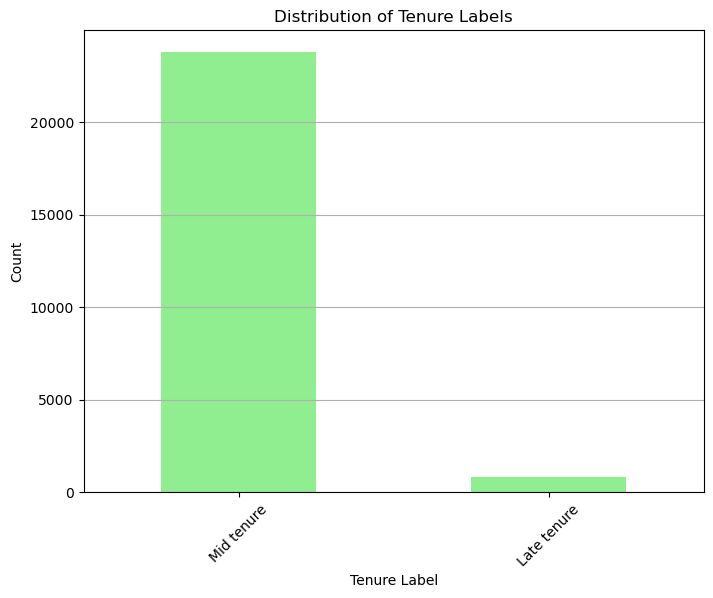

In [20]:
# Count the occurrences of each tenure label
tenure_label_counts = df['Tenure Label'].value_counts()

# Plot the distribution of tenure labels
plt.figure(figsize=(8, 6))
tenure_label_counts.plot(kind='bar', color='lightgreen')
plt.title('Distribution of Tenure Labels')
plt.xlabel('Tenure Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## Segment borrowers based on ticket size

In [28]:

df_sorted = df.sort_values(by='Amount Pending')

# Calculate total amount pending
total_amount_pending = df_sorted['Amount Pending'].sum()

# Calculate target amount for each cohort
target_amount = total_amount_pending / 3

# Initialize variables
cohort1 = []
cohort2 = []
cohort3 = []
cohort_amounts = [0, 0, 0]

# Assign borrowers to cohorts until sums are balanced
for _, row in df_sorted.iterrows():
    amount = row['Amount Pending']
    min_cohort = cohort_amounts.index(min(cohort_amounts))
    if cohort_amounts[min_cohort] + amount <= target_amount:
        if min_cohort == 0:
            cohort1.append(row.name)
        elif min_cohort == 1:
            cohort2.append(row.name)
        else:
            cohort3.append(row.name)
        cohort_amounts[min_cohort] += amount
    else:
        max_cohort = cohort_amounts.index(max(cohort_amounts))
        if max_cohort == 0:
            cohort1.append(row.name)
        elif max_cohort == 1:
            cohort2.append(row.name)
        else:
            cohort3.append(row.name)
        cohort_amounts[max_cohort] += amount

# Assign labels to borrowers based on cohorts
df.loc[cohort1, 'Ticket Size'] = 'Low ticket size'
df.loc[cohort2, 'Ticket Size'] = 'Medium ticket size'
df.loc[cohort3, 'Ticket Size'] = 'High ticket size'



## Give channel spend recommendations

In [15]:
import pandas as pd



# Segment borrowers into spend categories
whatsapp_bot_candidates = df[
    (df['Bounce String'].str.contains('S')) |  # Customers with great repayment behavior
    (df['Bounce String'].str.startswith('FEMI')) |  # Customers with first EMIs
    (df['Amount Pending'] <= 1000)  # Customers with low EMIs
]

voice_bot_candidates = df[
    ((df['City'].isin(['New York', 'San Francisco', 'Los Angeles'])) &  # Metropolitan areas
     (df['Interest Rate'] < 0.08)) |  # Low interest rate borrowers
    (df['Bounce String'].apply(lambda x: x.count('B')) < 2) |  # Customers with low bounce behavior
    ((df['Amount Pending'] > 1000) & (df['Amount Pending'] <= 2000))  # Customers with low or medium sized EMIs
]

human_calling_candidates = df  # Human calling will work on all scenarios

# Calculate total spend for each channel
whatsapp_bot_spend = len(whatsapp_bot_candidates) * 5
voice_bot_spend = len(voice_bot_candidates) * 10
human_calling_spend = len(human_calling_candidates) * 50

# Minimize overall spend while maximizing on-time repayment
total_spend = whatsapp_bot_spend + voice_bot_spend + human_calling_spend

print("Total Spend:")
print("WhatsApp Bot: ₹", whatsapp_bot_spend)
print("Voice Bot: ₹", voice_bot_spend)
print("Human Calling: ₹", human_calling_spend)
print("Overall Spend: ₹", total_spend)


Total Spend:
WhatsApp Bot: ₹ 116655
Voice Bot: ₹ 235450
Human Calling: ₹ 1229100
Overall Spend: ₹ 1581205


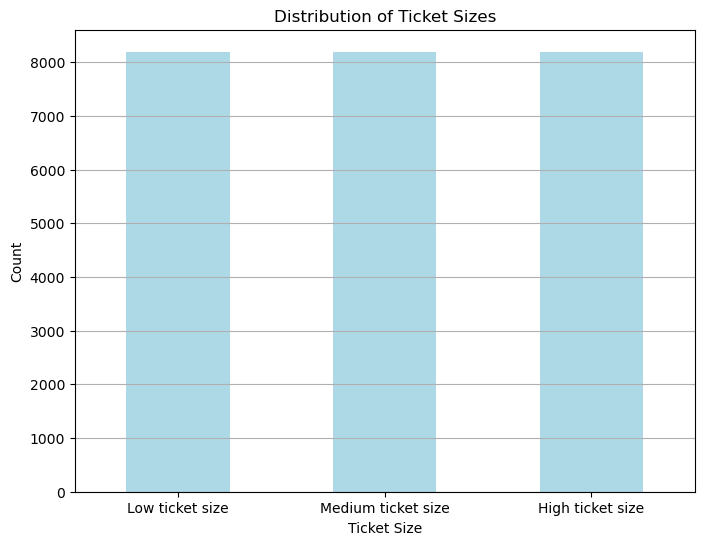

In [26]:
ticket_size_counts = df['Ticket Size'].value_counts()

# Plot the distribution of ticket sizes
plt.figure(figsize=(8, 6))
ticket_size_counts.plot(kind='bar', color='lightblue')
plt.title('Distribution of Ticket Sizes')
plt.xlabel('Ticket Size')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [27]:
df['Ticket Size'].value_counts()

Low ticket size       8196
Medium ticket size    8193
High ticket size      8193
Name: Ticket Size, dtype: int64

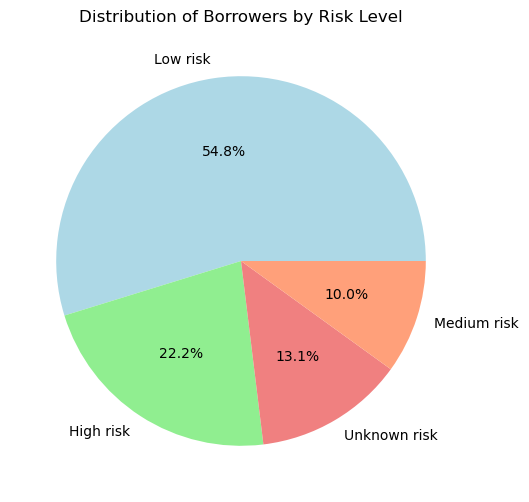

In [30]:
# Count the occurrences of each risk label
risk_label_counts = df['Risk Label'].value_counts()

# Plot the distribution of risk labels
plt.figure(figsize=(8, 6))
plt.pie(risk_label_counts, labels=risk_label_counts.index, autopct='%1.1f%%', colors=['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
plt.title('Distribution of Borrowers by Risk Level')
plt.show()


1. Summary of Borrowers Based on Risk:
The distribution of borrowers across different risk levels shows that a majority fall into the 'High risk' category, indicating potential challenges in repayment behavior.
A significant portion of borrowers also fall into the 'Low risk' category, suggesting a subset of borrowers with more favorable repayment behavior.
Medium and Unknown risk categories may represent borrowers with varying degrees of repayment reliability, requiring targeted communication strategies.

2. Summary of Borrowers Based on Ticket Sizes:
Borrowers are segmented into three ticket size cohorts: 'Low ticket size', 'Medium ticket size', and 'High ticket size'.
The distribution across ticket sizes allows for targeted resource allocation and communication strategies based on the financial magnitude of outstanding amounts.


3. Summary of Borrowers Based on Tenure Completion:
Borrowers are categorized into early tenure, mid tenure, and late tenure based on their remaining tenure period.
Understanding the distribution of borrowers based on tenure completion provides insights into their stage in the loan repayment process and informs strategies for timely repayment reminders.


4. Spend Recommendation for Borrowers:
Channel spend recommendations can be tailored based on borrower characteristics and behavior to optimize communication effectiveness while minimizing costs.
Recommendations may include leveraging cost-effective channels such as WhatsApp bot for borrowers with favorable repayment behavior, voice bot for borrowers with medium risk and preferred language proficiency, and human calling for high-risk borrowers or critical communication needs.
By prioritizing channels based on borrower segmentation, lenders can maximize outreach efficiency and repayment rates while minimizing expenditure.


5. Other Interesting Insights:
Further analysis can explore correlations between risk levels, ticket sizes, tenure completion, and repayment behavior to uncover additional patterns and insights.
Geographic, demographic, or socio-economic factors may also influence borrower behavior and repayment patterns, warranting deeper investigation for targeted intervention strategies.

In [32]:
pip install nbconvert[webpdf]



     ---------------------------------------- 83.4/83.4 kB 4.6 MB/s eta 0:00:00
     -------------------------------------- 101.4/101.4 kB 5.7 MB/s eta 0:00:00
